# Multifractal Detrended Moving Average (MF-DMA) Module

Reference:

Gu, Gao-Feng Gu, and Wei-Xing Zhou. "Detrending moving average algorithm for multifractals." Physical Review E, no. 82, 2010, pp. 011136,

Arianos, Sergio, and Anna Carbone. "Detrending moving average algorithm: A closed-form approximation of the scaling law." Physica A, no. 382, 2007, pp. 9–15

In [1]:
import array
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
files = 'https://raw.githubusercontent.com/y3kiys4/wqu_capstone_june2023_grp3626/main/SPX_1m_Dec2020_Jun2023.csv'

df = pd.read_csv(files)
# Set timestamp as index
df = df.set_index(df['Time'])
df.drop(['Time'], axis=1, inplace=True)
df.index = pd.to_datetime(df.index)

# Calculate log return
df['log_ret'] = 10000 * np.log(df.Price).diff() # 10,000 times log return

# Calculate the time difference in mininutes
df['deltaT'] = (df.index.to_series().diff().dt.days.mul(60*24, fill_value=0) +
                df.index.to_series().diff().dt.seconds.div(60, fill_value=0)
               )

df_1min = df[df['deltaT'] == 1]
df_1min['log_ret_sq'] = np.square(df_1min['log_ret'])
df_1min

C:\Users\cutef\AppData\Local\Temp\ipykernel_9708\374198705.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1min['log_ret_sq'] = np.square(df_1min['log_ret'])


,Price,log_ret,deltaT,log_ret_sq
Time,,,,
2020-12-01 00:01:00,3654.045,1.932292,1.0,3.733753
2020-12-01 00:02:00,3654.336,0.796346,1.0,0.634167
2020-12-01 00:03:00,3653.945,-1.070019,1.0,1.144941
2020-12-01 00:04:00,3653.845,-0.273681,1.0,0.074901
2020-12-01 00:05:00,3653.299,-1.494428,1.0,2.233315
...,...,...,...,...
2023-06-30 16:09:00,4446.311,-1.171689,1.0,1.372856
2023-06-30 16:10:00,4445.570,-1.666689,1.0,2.777852
2023-06-30 16:11:00,4445.332,-0.535379,1.0,0.286630


## 1. Construct the sequence of cumulative sums

<AxesSubplot:xlabel='Time'>

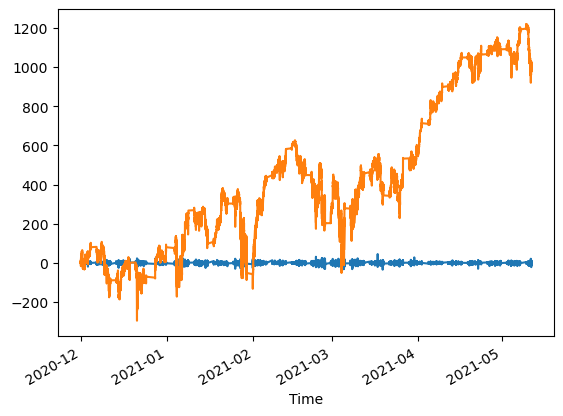

In [3]:
n_sample = 60 * 24 * 100

cs = pd.DataFrame(df_1min['log_ret'][:n_sample], columns = ['log_ret'])
cs['cum_sum'] = cs['log_ret']
cs['cum_sum'] = cs['cum_sum'].cumsum()

cs['log_ret'].plot()
cs['cum_sum'].plot()

In [4]:
cs

,log_ret,cum_sum
Time,,
2020-12-01 00:01:00,1.932292,1.932292
2020-12-01 00:02:00,0.796346,2.728638
2020-12-01 00:03:00,-1.070019,1.658619
2020-12-01 00:04:00,-0.273681,1.384938
2020-12-01 00:05:00,-1.494428,-0.109489
...,...,...
2021-05-11 15:56:00,10.282824,1007.360238
2021-05-11 15:57:00,0.599867,1007.960105
2021-05-11 15:58:00,1.657275,1009.617380


In [5]:
total_epoch = 50
lags = np.unique(np.logspace(0.5, 3, total_epoch).astype(int))
len_total = len(cs['cum_sum'])
q = 2

starttime_total = time.time()

F = []
len_total = len(cs['cum_sum'])
epoch = 1

print(f'Total epochs is {total_epoch}', '\n')
for lag in lags:
    starttime_epoch = time.time()
    mean_temp = []
    
    
    # Calculate moving average
    for i in range(len(cs['cum_sum'])-lag+1):
        mean_temp.append(np.mean(cs['cum_sum'][i:i+lag]))
    mean_temp.reverse()
    
    # Detrend
    diff_temp_subtractor = cs['cum_sum'][:lag-2:-1].values
    diff_temp = np.subtract(np.array(mean_temp), diff_temp_subtractor)
    
    # Slice into non-overlapping segments
    segs_temp = pd.DataFrame(np.resize(diff_temp, (len(diff_temp) // lag, lag))).T

    # Calculate fluctuation variance
    F_seg_sq_temp = np.array(np.var(segs_temp).mean(axis=0)) 
    
    # Calculate the qth order fluctuation function
    F_temp =  ((1 / lag) * (F_seg_sq_temp ** (q / 2)).sum()) ** (1 / q)
    
    F.append(F_temp)    
    
    endtime_epoch = time.time()
    print(f'Epoch {epoch}: q is {q}, lag is {lag}, F_q(n) is {F_temp}, \
    time spent is {int(endtime_epoch-starttime_epoch)} sec(s)')
    epoch += 1
    
endtime_total = time.time()
total_time = endtime_total - starttime_total

print('\n', f'F is {F}', '\n', f'Total time spent is: \
      {int(total_time // 60)} min {int(total_time % 60)} sec') 

Total epochs is 50 

Epoch 1: q is 2, lag is 3, F_q(n) is 0.7667537428140289,     time spent is 19 sec(s)
Epoch 2: q is 2, lag is 4, F_q(n) is 0.8321248722044918,     time spent is 19 sec(s)
Epoch 3: q is 2, lag is 5, F_q(n) is 0.8651951467271677,     time spent is 19 sec(s)
Epoch 4: q is 2, lag is 6, F_q(n) is 0.8964912362524614,     time spent is 19 sec(s)
Epoch 5: q is 2, lag is 7, F_q(n) is 0.9117006821239737,     time spent is 19 sec(s)
Epoch 6: q is 2, lag is 8, F_q(n) is 0.9172830198178245,     time spent is 19 sec(s)
Epoch 7: q is 2, lag is 9, F_q(n) is 0.9268206913086224,     time spent is 19 sec(s)
Epoch 8: q is 2, lag is 10, F_q(n) is 0.9310396884217265,     time spent is 19 sec(s)
Epoch 9: q is 2, lag is 11, F_q(n) is 0.9399279441279594,     time spent is 19 sec(s)
Epoch 10: q is 2, lag is 12, F_q(n) is 0.9506340554966954,     time spent is 19 sec(s)
Epoch 11: q is 2, lag is 14, F_q(n) is 0.9403379411215751,     time spent is 19 sec(s)
Epoch 12: q is 2, lag is 16, F_q(n) is

In [6]:
log10_lag = np.log10(lags)
log10_F = np.log10(F) 
hurst_hat = np.polyfit(log10_lag, log10_F, 1)[0]
print(f'The estimated Hurst exponent is {hurst_hat}')

The estimated Hurst exponent is 0.022610854906110926


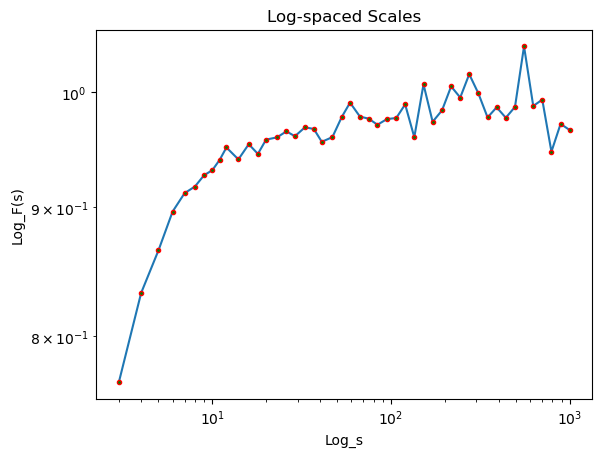

In [7]:
plt.loglog(lags, F, marker="o", markersize=3, markeredgecolor="red", markerfacecolor="green")
plt.xlabel('Log_s')
plt.ylabel('Log_F(s)')
plt.title('Log-spaced Scales')
plt.show()